In [ ]:
## ***Uncertainty Quantification***

Exercise 2 

Prof. Dr. Martin Frank
#### **EXERCISE SHEET 2**

In [1]:
import numpy as np
import sobol_seq
from pyDOE import *
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm

In [ ]:
&nbsp;

**EXERCISE 1)**

Consider the SIR-Model ([1]-[4]) for the spread of infectious diseases like the Corona virus.

The total population N is divided into the groups of **susceptible**, **infected** and **removed** (i.e. dead or recovered) individuals: 
**N = S + I + R**

&nbsp;

![alt text](https://drive.google.com/uc?export=view&id=1Cv8I_JHky6dLBO9JTobvYkKAaL9Qy0_X)

&nbsp;

The model assumes that
- every individual can only be infected once, then they are either immune or dead
- the categories dead and immune are summarized in the compartment "Removed"
- there is no incubation time
- the respective rates are constant


The following system of equations describes the flow of population between the three compartments

&nbsp;
$$ \frac{dS(t)}{dt} = - \beta S(t) I(t)$$

&nbsp;
$$ \frac{dI(t)}{dt} = \beta S(t) I(t) - \gamma I(t)$$

&nbsp;
$$ \frac{dR(t)}{dt} = \gamma I(t)$$

&nbsp;

$N(t)=N,\;\; S(t)\geq0,\;\; I(t)\geq0, \;\;R(t)\geq0$,

where the parameter $\beta$ represents the infection rate (number of infections per infected person per time unit (day)) and $\gamma$ represents the combined death and recovery rate (number of dead or recovered individuals per infectious person per day). 

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Derive a formula for the maximum number of infectious individuals depending on $\beta$ and $\gamma$.           
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;   How do $S(t), I(t) $and $R(t)$ behave for $t \rightarrow \infty$ ?

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  What can you say about the growth rate of infections?


&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Run the code below for different choices of $\beta$ and $\gamma$, how does the number of infections react?            
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Can you explain the development of the different curves for specific parameter choices? 


Reproduction Number = 0.9
Max. number of infections = 7358370.912021279


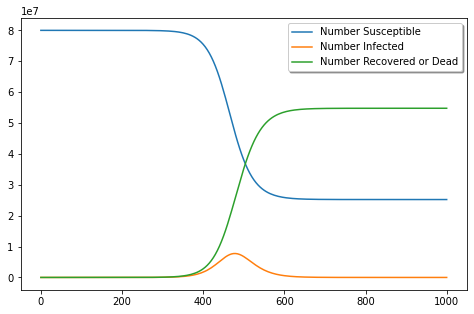

In [8]:
### (b) ###

#Set parameters
N = 80000000  #Population size
S_0 = N       #Number susceptible at time 0
I_0 = 1       #Number infected at time 0
R_0 = 0       #Number removed (recovered & immune or dead) at time 0

beta = 0.9/9/N          # number infections caused by one infected person per day
                        #(Currently in Germany, one person infects 0.9 other people while infectious (reproduction number) and is infectious for 8-10 days)
gamma = 0.0353 + 0.025  # death + recovery rate, number dead or recovered per day

t_0 = 0
t_end = 200            # timesteps
h=5                    # time step = h days

def f_S(I_t,S_t,beta):
  return -beta*I_t*S_t

def f_I(I_t,S_t,beta,gamma):
  return beta*S_t*I_t-gamma*I_t

def f_R(I_t,gamma):
  return gamma*I_t

def Euler (f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,T,beta,gamma):
  times = t_0 + np.arange(T+1)*h
  I=np.zeros(T+1,)
  I[0]=I_0

  S=np.zeros(T+1,)
  S[0]=S_0

  R=np.zeros(T+1,)
  R[0]=R_0
  
  for t in range(T):
    S[t+1] = min(max(S[t] + h*f_S(I[t],S[t],beta),0),N)
    I[t+1] = min(max(I[t] + h*f_I(I[t],S[t],beta,gamma),0),N)
    R[t+1] = min(max(R[t] + h*f_R(I[t],gamma),0),N)
  return S, I, R

S, I, R = Euler(f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,t_end,beta,gamma)
plt.figure(figsize=(8,5))
plt.plot(h*np.arange(t_end+1),S,label="Number Susceptible")
plt.plot(h*np.arange(t_end+1),I,label="Number Infected")
plt.plot(h*np.arange(t_end+1),R,label="Number Recovered or Dead")
_=plt.legend(shadow=True, fancybox=True)
print("Reproduction Number = {0}".format(beta*9*N))
print("Max. number of infections = {0}".format(gamma/beta*math.log(gamma/beta)-gamma/beta-gamma/beta*math.log(S_0)+N))

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) The last weeks have shown that there is a lot of uncertainty in Corona virus predictions, since the actual parameter values depend on uncertain/unknown factors 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  such as the effect of restrictive measures, discipline of the population or quality and availability of intensive care. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Therefore we now assume the parameters $Q=(\beta,\gamma)^T$ are normally distributed with

$$\text{ mean } \bar q =\begin{pmatrix}  0.1333/N \\ 0.1 \end{pmatrix}$$
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
$$\text{ covariance matrix } \sigma_q^2 = \begin{pmatrix} (0.05/N)^2 & 0\\ 0 & 0.02^2\end{pmatrix}.$$

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  We are interested in the mean and the variance of $S, I $ and $R$ over a time span of 1000 days. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  To approximate these, use Monte-Carlo and
quasi-Monte-Carlo sampling and fill in the indicated blanks in the second code block.           
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Run the code for an increasing number of samples, what do you observe? 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Take a look at the expected values for $S, I, R$ $\pm$ the respective standard deviations. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  In which sense are the values unrealistic? Could the model be extended to be more realistic?

In [9]:
### (c) ###

#Numbers of samples 
M=10000

#Generate samples for MC and quasi-MC
q_bar = np.zeros(2,)
q_bar[0] = 1.2/9/N
q_bar[1] = 0.08
sigma_q = np.zeros((2,2))
sigma_q[0][0] = (0.04/N)**2
sigma_q[1][1] = 0.02**2

## Fill in the blanks below ###

## Generate random samples of beta and gamma for MC and qMC (according to distribution given in exercise above)
samples_MC=  #random sample

samples_qMC= #// 
             # You might need several lines here, use quasi-random sequence of your choice from Exercise 1
             #//

#Initialise 
mu_qMC = np.zeros((3,t_end+1))
mu_MC = np.zeros((3,t_end+1))
Sn_qMC = np.zeros((3,t_end+1))
Sn_MC = np.zeros((3,t_end+1))

result_i_qMC = np.zeros((3,t_end+1))
result_i_MC = np.zeros((3,t_end+1))

## This loop incrementally computes mean and variances for S, I and R over random samples for MC and qMC
for i in range(M):
    
  ## Look up incremental mean and variance computation and fill in blanks

                #// Fill in Monte Carlo mean/variance computation here...
 result_i_MC =  #   :
                #   :
  mu_qMC =      #   :
  Sn_qMC =      #//
    

                  #// Fill in quasi-Monte Carlo mean/variance computation here...
  result_i_qMC =  #   :
                  #   :
  mu_MC =         #   :
  Sn_MC =         #//




plt.figure(figsize=(12,6))
plt.plot(h*np.arange(t_end+1),mu_qMC[1,:],linestyle='dotted',color='blue', label = "Expected number of infections (quasi MC)")
plt.plot(h*np.arange(t_end+1),mu_MC[1,:],color='blue', label = "Expected number of infections (MC)")
plt.plot(h*np.arange(t_end+1),Sn_qMC[1,:],linestyle='dotted',color='red', label = "Std. Dev of number of infections (quasi MC)")
plt.plot(h*np.arange(t_end+1),Sn_MC[1,:],color='red', label = "Std. Dev number of infections (MC)")
plt.title("qMC vs. MC for number of infections")
_=plt.legend(shadow=True, fancybox=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(27,11))

ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:],label="Expected number Susceptible",color='C0')
ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:]+Sn_MC[0,:],linestyle='dotted',color='C0', label=r'$E[S] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:]-Sn_MC[0,:],linestyle='dotted',color='C0')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:],label="Expected number Infected",color='C1')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:]+Sn_MC[1,:],linestyle='dotted',color='C1', label=r'$E[I] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:]-Sn_MC[1,:],linestyle='dotted',color='C1')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:],label="Expected number Recovered or Dead",color='C2')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:]+Sn_MC[2,:],linestyle='dotted',color='C2', label=r'$E[R] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:]-Sn_MC[2,:],linestyle='dotted',color='C2')
ax[0].set_title("S,I,R expected values & standard dev. Monte Carlo")
_=ax[0].legend(shadow=True, fancybox=True)


ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:],label="Expected number Susceptible",color='C0')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:]+Sn_qMC[0,:],linestyle='dotted',color='C0', label=r'$E[S] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:]-Sn_qMC[0,:],linestyle='dotted',color='C0')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:],label="Expected number Infected",color='C1')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:]+Sn_qMC[1,:],linestyle='dotted',color='C1', label=r'$E[I] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:]-Sn_qMC[1,:],linestyle='dotted',color='C1')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:],label="Expected number Recovered or Dead",color='C2')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:]+Sn_qMC[2,:],linestyle='dotted',color='C2', label=r'$E[R] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:]-Sn_qMC[2,:],linestyle='dotted',color='C2')
ax[1].set_title("S,I,R expected values & standard dev. quasi-Monte Carlo")
_=ax[1].legend(shadow=True, fancybox=True)

SyntaxError: invalid syntax (423725662.py, line 17)

&nbsp;

---

##### Some literature on the SIR-Model:

[1] *Kermack, W. O., & McKendrick, A. G.* (1927). A contribution to the mathematical theory of epidemics. Proceedings of the royal society of london. Series A, Containing papers of a mathematical and physical character, 115(772), 700-721.

[2] *Brauer, F.* (2005). The Kermack–McKendrick epidemic model revisited. Mathematical biosciences, 198(2), 119-131.

[3] *Satsuma, J., Willox, R., Ramani, A., Grammaticos, B., & Carstea, A. S.* (2004). Extending the SIR epidemic model. Physica A: Statistical Mechanics and its Applications, 336(3-4), 369-375.

[4] *Nesteruk, I.* (2020). SIR-simulation of Corona pandemic dynamics in Europe. medRxiv.


In [ ]:
###### &nbsp;

**EXERCISE 2)**

Assume that we have a sequence of random numbers $(Z_l)_{l\in \mathbb{N}}$ with $Z = \lim_{l \rightarrow \infty} Z_l.^{[1]}$ We wish to approximate $E[Z]$ with Multi-Level Monte Carlo (MLMC) by sampling from finitely many $Z_l$ with $l = 0,...,L$. The MLMC estimator Y is given by

$$ Y = \sum_{l=0}^L Y_l, \quad Y_l = N_l^{-1}\sum_{n=1}^{N_l}(Z^{(l,n)}-Z^{(l-1,n)})$$

with $Z_{-1} =0$.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Show that 

$$ E[Y] = E[Z_L], \quad \text{Var}[Y] = \sum_{l=0}^L N_l^{-1}V_l, \text{ with } V_l = \text{Var}[Z_l-Z_{l-1}]. $$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Show that the mean square error (MSE) of the MLMC estimator $Y$ with maximum level $L$ is given by 

$$ MSE = E[(Y-E[Z])^2] = \text{Var}[Y] + (E[Y]-E[Z])^2.$$

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;     Interpret the two terms on the right hand side by using the results from part (a). What is the difference to the lecture?                         
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  How does the choice of $L, N_0, ... , N_L$ affect each term?

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) We now want to choose the maximum level $L$ as well as the number of samples for each level such that $MSE \leq \epsilon^2$                             
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  while the costs are minimal. Assume that the given sequence fulfills

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (i) $\vert Z_l-Z\vert \leq c_1 2^{-\alpha l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (ii) $V_l \leq c_2 2^{-\beta l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (iii) $K_l \leq c_3 2^{\gamma l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  with costs $K_l$. Show that the optimal parameters $L, N_0, ..., N_L$ in terms of $\alpha, \beta, \gamma, c_{1,2,3} $ are

$$L = \left\lceil{-\frac{1}{\alpha}\log_2\left(\frac{\varepsilon}{\sqrt{2}c_1}\right)}\right\rceil, \quad N_l = \left\lceil{\frac{2c_2}{\varepsilon^2}2^{-(\gamma+\beta)l/2}\sum_{k = 0}^{L} 2^{(\gamma-\beta)k/2}}\right\rceil.$$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  **Hint:** Start with $\text{Var}[Y]=\varepsilon^2/2$ and $(E[Y]-E[Z])^2=\varepsilon^2/2$ to ensure $MSE=\varepsilon^2$.

----
$^{[1]}$ You can think of $Z_l$ as an approximation of an ODE solution resulting from a numerical discretization with refinement level $l$. 

In [ ]:
&nbsp;

**EXERCISE 3)**

We now want to use the results from Exercise 2 in an application. For this, run the code below and consider questions (a)-(c).

Let $Z=\mathcal{u}(t_{end},X)$, where $X$ is uniformly distributed in [0,1] and $\mathcal{u}$ is the solution of

&nbsp;

$$
 \mathcal{u'} = -\lambda \mathcal{u}, \;\:\: \mathcal{u}(t=0,X) = X,
$$

&nbsp;

The sequence $Z_l$ is given by an Euler method

&nbsp;

$$
\mathcal{u_l}(t_{n+1}) = \mathcal{u_l}(t_{n}) - \Delta t_c 2^{-l} \lambda \mathcal{u_l}(t_{n}), \;\:\: \mathcal{u_l}(0,X) = X.
$$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Determine $\alpha, \beta, \gamma$ and estimate $c_1,c_2,c_3$ from Exercise 3 c).
                             
 &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **Hint:** Use a Taylor expansion to estimate $c_1,c_2,c_3$.

 &nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Look at the code and add the parameters for this problem.

 &nbsp;
 
 &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) Think of advantages and disadvantages of MLMC. Can we obtain the expected value with given accuracy if the problem parameters are not known?

In [10]:
#Define required functions

#Function to determine sequence Zl
def ForwardEuler (l,tEnd,dtCoarse,X,lambda_c):
  if l==-1:
    Pl = 0
    cost = 0
    return Pl, cost
  
  dt = dtCoarse*2**(-l)
  Nt = round(tEnd/dt)

  u=X

  for i in range(1,Nt+1):
    uNew = u -dt*lambda_c*u
    u=uNew

  Pl = u
  cost = Nt

  return Pl, cost

### Multi-Level Monte Carlo Estimator ###
def MCLevelEstimator (l, Nl, tEnd, dtCoarse, lambda_c):
  Yl=0
  for i in range(1,Nl+1):
    X=np.random.uniform(0,1,(1,1))
    ZlM, costLM = ForwardEuler (l-1,tEnd,dtCoarse,X,lambda_c)
    Zl, costL = ForwardEuler (l,tEnd,dtCoarse,X,lambda_c)
    Yl = Yl + Zl -ZlM

  Yl = (1/Nl)*Yl
  cost= (costLM + costL)*Nl 

  return Yl, cost

def MLMCEstimator (alpha, beta, gamma, c1, c2, c3, epsilon, tEnd, lambda_c):
  dtCoarse=1/lambda_c

  #Compute L according to Exercise 3c)
  L = math.ceil (math.log2(epsilon/(np.sqrt(2)*c1))/(-alpha))
  print("Max number of levels is {0}".format(L))

  #Compute number of MC samples for all levels according to Exercise 2c)
  N= np.zeros((L+1,1))
  sumL= sum(2**((gamma-beta)*np.arange(L+1)/2))

  for l in range(L+1):
    N[l]=math.ceil(2*c2/(epsilon**2)*2**(-0.5*(gamma+beta)*l)*sumL)
  
  Y=0
  cost=0

  for l in range(L+1):
    print("Computing level {0}".format(l))
    print("Number MC samples is {0}".format(N[l]))
    Yl, costL = MCLevelEstimator(l,int(N[l]),tEnd,dtCoarse,lambda_c)
    Y = Y + Yl
    cost = cost + costL
  
  return Y, cost, L


### Monte Carlo Estimator ###
def MCEstimator (L, N, tEnd, dt, lambda_c):
  Yl = 0
  for i in range(1,N+1):
    Z=np.random.uniform(0,1,(1,1))
    Pl , costL = ForwardEuler (L,tEnd,dt,Z,lambda_c)
    Yl = Yl + Pl
  
  Yl= (1/N)*Yl
  cost = costL*N

  return Yl, cost

In [11]:
#Set parameters and compare methods MLMC and MC

#Problem settings
tEnd = 2
lambda_c = 0.5
dtCoarse = 1/lambda_c

#Desired level of accuracy
epsilon = 0.001

#-----------MLMC------------#
#Properties of numerical discretization
#Convergence/growth parameters
alpha = 
beta =                                    #
gamma =                                   #  \
#Constants                                   fill in values for parameters and constants
c1 =                                      #  /
c2 =                                      #
c3 = 

#Approximate expectation value with MLMC & return cost and max. refinement level
Y, cost, L = MLMCEstimator (alpha, beta, gamma, c1, c2, c3, epsilon, tEnd, lambda_c)

#------------MC-------------#
#Estimate max. samples to reach desired accuracy with MC
V0 = c1**2
nMC = math.ceil(V0/epsilon**2)

print("Number of MC samples is {0}".format(nMC))

YMC, costMC = MCEstimator (L,nMC, tEnd, dtCoarse, lambda_c)

#----------Results----------#
print("MC error is {0}".format(abs(0.5*math.exp(-lambda_c*tEnd)-YMC)))
print("MLMC error is {0}".format(abs(0.5*math.exp(-lambda_c*tEnd)-Y)))

if costMC/cost > 1:
  print("MC is {0} times more expensive than MLMC".format(costMC/cost))
else:
  print("MLMC is {0} times more expensive than MC".format(cost/costMC))

SyntaxError: invalid syntax (1152098535.py, line 14)